# Analysis of Shanwen Gao's Speech

*Alex Zhao | Dec. 2024*

At the end of 2024, [Shanwen Gao](https://www.linkedin.com/in/shanwen-gao-8ab8585/?originalSubdomain=cn) delivered a provocative [speech](https://www.youtube.com/watch?v=1TiZCP5Mnms) that challenged conventional wisdom about China’s economic recovery after the bubble burst. He contended that:

  - **Official GDP figures post-bubble are overstated by roughly 3 percentage points.**
  - **Adjusting GDP downward yields lower predicted consumption growth, closer to what is observed.**
  - **Demographic factors (a higher share of young and elderly populations) further depress consumption growth.**

Intrigued by these claims, I eagerly downloaded data from [National Bureau of Statistics of China](https://www.stats.gov.cn/english/) to put Gao’s assertions to the test. In this project, I lead with the analysis results—my primary focus—as I explore whether his statements hold true and uncover additional insights from his speech:

1. Overstated GDP Figures:
   - The official GDP-to-consumption regression (with an intercept of ~1.81 and slope of ~0.89) predicts much higher consumption growth 
     when applied to official GDP growth figures in the post-bubble period.
   - However, actual observed consumption growth in 2022 was much lower (near -0.25%). When we adjust the GDP growth downward by about 3 percentage points,
     the model predicts consumption growth of ~3.44% (2022) and ~3.27% (2023). This supports Gao Shanwen’s claim that official GDP figures are inflated post-bubble.

2. Structural Break and Protracted Recovery:
   - Gao Shanwen’s speech argues that after the bubble bursts, it takes roughly 9 years for the economy to return to normal growth.
   - The failure of the pre-bubble GDP-consumption relationship (both in the official and adjusted models) to capture the dramatic rebound (e.g., actual consumption growth of 7.22% in 2023) indicates a structural break.
   - This suggests that additional factors are influencing the post-bubble dynamics, consistent with the prolonged adjustment period mentioned in the speech.

3. Demographic Effects:
   - The demographic regression yields the model:
         Consumption Growth = 39.18 + 0.70 * GDP_growth - 119.12 * Young_Share - 139.17 * Elderly_Share
     implying that higher shares of young and elderly populations are associated with significantly lower consumption growth.
   - This finding aligns with the speech’s observation that regions with a higher proportion of young people experience weaker consumption growth,
     likely due to lower income expectations and consumer confidence.
   - The demographic model’s post-bubble predictions (around 1.72% in 2022 and 1.55% in 2023) further underscore the downward pressure on consumption,
     reinforcing the notion of a protracted recovery.

Overall, the empirical results bolster Gao Shanwen’s argument:
   - Official GDP growth figures are likely overstated (by about 3 percentage points).
   - When corrected, the expected consumption growth is significantly lower, reflecting the distorted state of the economy.
   - Demographic pressures further depress consumption, suggesting that a full recovery to pre-bubble levels will take considerable time (on average 9 years).

And below is the whole process to gain those interpretations, please enjoy:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Data Loading and Preprocessing

In [24]:
# Read the Excel file (using xlrd for .xls files)
df = pd.read_excel('/Users/zichengzhao/Downloads/gao/data.xls', engine='xlrd')

# The header is in the second row. Set that row as column names and drop the first two rows.
df.columns = df.iloc[1]
df = df.iloc[2:]

# Transpose so that each row represents a year and set the '指标' as the index.
df.set_index('指标', inplace=True)
df = df.transpose()

# Convert the index (e.g., "2023年") to integer years.
df.index = df.index.astype(str).str.replace('年', '').astype(int)
df.index.name = 'Year'

# Convert all columns to numeric (errors become NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Check missing values
print("Missing values per column:")
print(df.isna().sum())

# Forward-fill missing values (using ffill, as method='ffill' is deprecated in the future)
df.ffill(inplace=True)

Missing values per column:
指标
国内生产总值(亿元)            0
劳动力(万人)               1
城镇登记失业人数(万人)          0
城镇登记失业率(%)            2
社会消费品零售总额(亿元)         0
全社会固定资产投资(亿元)         0
房地产开发投资(亿元)           0
年末总人口(万人)             0
0-14岁人口(万人)           0
15-64岁人口(万人)          0
65岁及以上人口(万人)          0
居民消费价格指数(上年=100)      0
商品零售价格指数(上年=100)      1
固定资产投资价格指数(上年=100)    4
dtype: int64


## 2. Rename Columns and Compute Growth Rates

In [25]:
df.rename(columns={
    '国内生产总值(亿元)': 'GDP',
    '劳动力(万人)': 'Labor_Force',
    '城镇登记失业人数(万人)': 'Urban_Registered_Unemployed_Population_(10k)',
    '城镇登记失业率(%)': 'Urban_Registered_Unemployment_Rate_(%)',
    '社会消费品零售总额(亿元)': 'Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)',
    '全社会固定资产投资(亿元)': 'Total_Social_Fixed_Asset_Investment_(100M_Yuan)',
    '房地产开发投资(亿元)': 'Real_Estate_Development_Investment_(100M_Yuan)',
    '年末总人口(万人)': 'Total_Population_at_Year_End_(10k)',
    '0-14岁人口(万人)': 'Population_Aged_0_14_(10k)',
    '15-64岁人口(万人)': 'Population_Aged_15_64_(10k)',
    '65岁及以上人口(万人)': 'Population_Aged_65_and_Above_(10k)',
    '居民消费价格指数(上年=100)': 'Consumer_Price_Index_(Previous_Year=100)',
    '商品零售价格指数(上年=100)': 'Retail_Price_Index_(Previous_Year=100)',
    '固定资产投资价格指数(上年=100)': 'Fixed_Asset_Investment_Price_Index_(Previous_Year=100)'
}, inplace=True)

df = df.sort_index()

# Compute annual percentage growth rates for GDP and consumption.
df['GDP_growth'] = df['GDP'].pct_change() * 100
df['Consumption_growth'] = df['Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)'].pct_change() * 100

print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
指标              GDP   Labor_Force  \
count  2.000000e+01     19.000000   
mean   6.491407e+05  78052.368421   
std    3.533720e+05   1348.870483   
min    1.618402e+05  75290.000000   
25%    3.411994e+05  76954.500000   
50%    6.182631e+05  78392.000000   
75%    9.360896e+05  79013.500000   
max    1.260582e+06  80091.000000   

指标     Urban_Registered_Unemployed_Population_(10k)  \
count                                     20.000000   
mean                                     954.550000   
std                                      101.345929   
min                                      827.000000   
25%                                      902.500000   
50%                                      935.500000   
75%                                      976.000000   
max                                     1203.000000   

指标     Urban_Registered_Unemployment_Rate_(%)  \
count                               18.000000   
mean                                 4.061111   
st

## 3. Correlation Analysis

In [26]:
cor_matrix = df[['GDP', 'Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)',
                 'Total_Social_Fixed_Asset_Investment_(100M_Yuan)',
                 'Real_Estate_Development_Investment_(100M_Yuan)',
                 'Consumer_Price_Index_(Previous_Year=100)',
                 'GDP_growth', 'Consumption_growth']].corr()
print("\nCorrelation Matrix:")
print(cor_matrix)


Correlation Matrix:
指标                                                     GDP  \
指标                                                           
GDP                                               1.000000   
Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)  0.993934   
Total_Social_Fixed_Asset_Investment_(100M_Yuan)   0.986988   
Real_Estate_Development_Investment_(100M_Yuan)    0.958457   
Consumer_Price_Index_(Previous_Year=100)         -0.397175   
GDP_growth                                       -0.728890   
Consumption_growth                               -0.774715   

指标                                                Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)  \
指标                                                                                                   
GDP                                                                                       0.993934   
Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)                                          1.000000   
Total_Social

## 4. Post-Bubble Analysis: Official vs. Adjusted GDP Models

In [27]:
# Define pre-bubble (years <= 2021) and post-bubble (years >= 2022)
pre_bubble = df[df.index <= 2021].dropna(subset=['GDP_growth', 'Consumption_growth']).copy()
post_bubble = df[df.index >= 2022].copy()

# --- Official GDP Model ---
X_pre = pre_bubble[['GDP_growth']].values
y_pre = pre_bubble['Consumption_growth'].values
model = LinearRegression()
model.fit(X_pre, y_pre)
print("\nOfficial GDP-to-Consumption Model:")
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])
# The model: Consumption Growth = Intercept + Slope * GDP Growth

# Create 'Predicted_Consumption_Official' for post-bubble period.
df.loc[df.index >= 2022, 'Predicted_Consumption_Official'] = model.predict(
    df.loc[df.index >= 2022, ['GDP_growth']].values
)

# --- Adjusted GDP Model ---
# According to the speech, official GDP growth is overstated by ~3 percentage points.
df['GDP_growth_adjusted'] = df['GDP_growth']
df.loc[df.index >= 2022, 'GDP_growth_adjusted'] = df.loc[df.index >= 2022, 'GDP_growth'] - 3.0

# Use 2021 as the baseline for adjusted GDP.
gdp_2021 = df.loc[2021, 'GDP']
df['GDP_adjusted'] = np.nan
df.loc[2021, 'GDP_adjusted'] = gdp_2021

# Iteratively compute adjusted GDP for years after 2021.
for year in df.index[df.index > 2021]:
    prev_year = year - 1
    growth_rate = df.loc[year, 'GDP_growth_adjusted'] / 100.0
    df.loc[year, 'GDP_adjusted'] = df.loc[prev_year, 'GDP_adjusted'] * (1 + growth_rate)

# Recompute adjusted GDP growth.
df['GDP_growth_adjusted'] = df['GDP_adjusted'].pct_change() * 100

# Predict consumption growth using adjusted GDP growth.
X_post_adjusted = df.loc[df.index >= 2022, ['GDP_growth_adjusted']].values
predicted_consumption_adjusted = model.predict(X_post_adjusted)
df.loc[df.index >= 2022, 'Predicted_Consumption_Adjusted'] = predicted_consumption_adjusted

# Verify that the predicted columns exist.
print("\nColumns in the DataFrame:")
print(df.columns)

# Display a comparison for the post-bubble period.
comparison = df.loc[df.index >= 2022, ['Consumption_growth', 
                                         'Predicted_Consumption_Official', 
                                         'Predicted_Consumption_Adjusted']]
print("\nPost-Bubble Consumption Growth Comparison:")
print(comparison)


Official GDP-to-Consumption Model:
Intercept: 1.8052591648627914
Slope: 0.8924959539248528

Columns in the DataFrame:
Index(['GDP', 'Labor_Force', 'Urban_Registered_Unemployed_Population_(10k)',
       'Urban_Registered_Unemployment_Rate_(%)',
       'Total_Retail_Sales_of_Consumer_Goods_(100M_Yuan)',
       'Total_Social_Fixed_Asset_Investment_(100M_Yuan)',
       'Real_Estate_Development_Investment_(100M_Yuan)',
       'Total_Population_at_Year_End_(10k)', 'Population_Aged_0_14_(10k)',
       'Population_Aged_15_64_(10k)', 'Population_Aged_65_and_Above_(10k)',
       'Consumer_Price_Index_(Previous_Year=100)',
       'Retail_Price_Index_(Previous_Year=100)',
       'Fixed_Asset_Investment_Price_Index_(Previous_Year=100)', 'GDP_growth',
       'Consumption_growth', 'Predicted_Consumption_Official',
       'GDP_growth_adjusted', 'GDP_adjusted',
       'Predicted_Consumption_Adjusted'],
      dtype='object', name='指标')

Post-Bubble Consumption Growth Comparison:
指标    Consumption_growt

## 5. Demographic Analysis

In [28]:
# Create demographic share variables.
df['Young_Share'] = df['Population_Aged_0_14_(10k)'] / df['Total_Population_at_Year_End_(10k)']
df['Working_Age_Share'] = df['Population_Aged_15_64_(10k)'] / df['Total_Population_at_Year_End_(10k)']
df['Elderly_Share'] = df['Population_Aged_65_and_Above_(10k)'] / df['Total_Population_at_Year_End_(10k)']

# Use pre-bubble data for the demographic regression.
pre_bubble_demo = df[df.index <= 2021].dropna(subset=['GDP_growth', 'Consumption_growth', 'Young_Share', 'Elderly_Share']).copy()
X_demo = pre_bubble_demo[['GDP_growth', 'Young_Share', 'Elderly_Share']].values
y_demo = pre_bubble_demo['Consumption_growth'].values
model_demo = LinearRegression()
model_demo.fit(X_demo, y_demo)
print("\nDemographic Model Coefficients:")
print("Intercept:", model_demo.intercept_)
print("Coefficients:", model_demo.coef_)
# The model is: Consumption Growth = Intercept + 0.70*GDP_growth - 119.12*Young_Share - 139.17*Elderly_Share

# Predict post-bubble consumption growth using the demographic model.
post_bubble_demo = df[df.index >= 2022].copy()
post_bubble_demo.dropna(subset=['GDP_growth', 'Young_Share', 'Elderly_Share'], inplace=True)
X_post_demo = post_bubble_demo[['GDP_growth', 'Young_Share', 'Elderly_Share']].values
post_bubble_demo['Predicted_Consumption_Demo'] = model_demo.predict(X_post_demo)
print("\nPost-Bubble Demographic Model Prediction:")
print(post_bubble_demo[['Consumption_growth', 'Predicted_Consumption_Demo']])


Demographic Model Coefficients:
Intercept: 39.184125262358734
Coefficients: [   0.70223784 -119.12396461 -139.1749654 ]

Post-Bubble Demographic Model Prediction:
指标    Consumption_growth  Predicted_Consumption_Demo
Year                                                
2022           -0.247423                    1.720183
2023            7.223187                    1.550313


## 6. Visualization

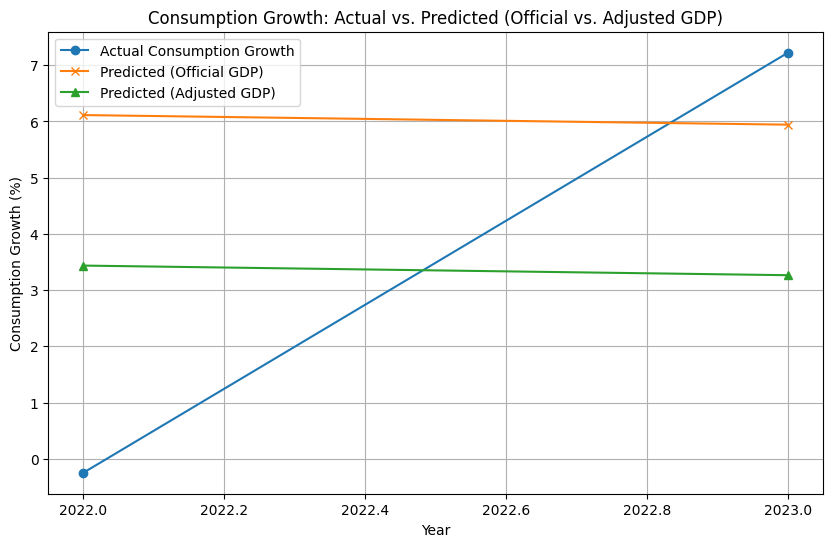

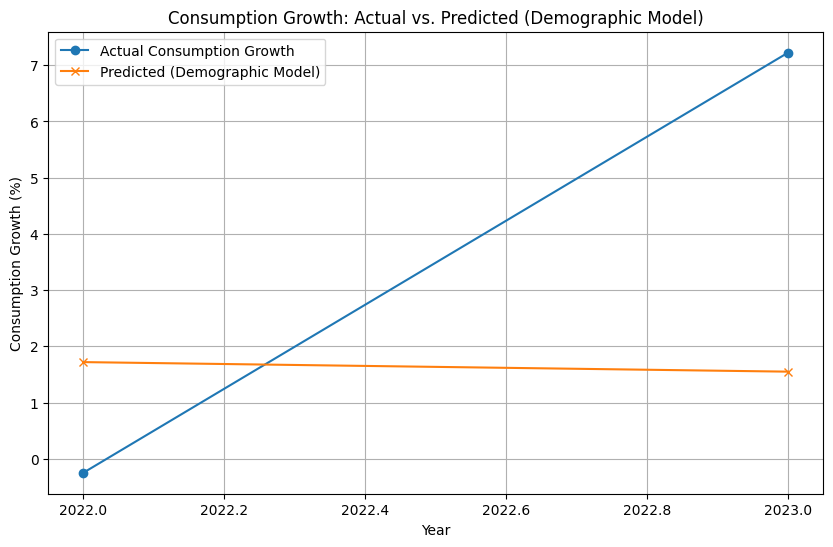

In [29]:
# Plot Actual vs. Predicted Consumption Growth (Official vs. Adjusted)
plt.figure(figsize=(10,6))
post_years = df[df.index >= 2022].index
plt.plot(post_years, df.loc[post_years, 'Consumption_growth'], marker='o', label='Actual Consumption Growth')
plt.plot(post_years, df.loc[post_years, 'Predicted_Consumption_Official'], marker='x', label='Predicted (Official GDP)')
plt.plot(post_years, df.loc[post_years, 'Predicted_Consumption_Adjusted'], marker='^', label='Predicted (Adjusted GDP)')
plt.title('Consumption Growth: Actual vs. Predicted (Official vs. Adjusted GDP)')
plt.xlabel('Year')
plt.ylabel('Consumption Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs. Predicted Consumption Growth (Demographic Model)
plt.figure(figsize=(10,6))
plt.plot(post_bubble_demo.index, post_bubble_demo['Consumption_growth'], marker='o', label='Actual Consumption Growth')
plt.plot(post_bubble_demo.index, post_bubble_demo['Predicted_Consumption_Demo'], marker='x', label='Predicted (Demographic Model)')
plt.title('Consumption Growth: Actual vs. Predicted (Demographic Model)')
plt.xlabel('Year')
plt.ylabel('Consumption Growth (%)')
plt.legend()
plt.grid(True)
plt.show()